In [1]:
import os
from dotenv import load_dotenv
import uuid
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

PRIMARY_MODEL = "gpt-5-nano"

llm = ChatOpenAI(
    model=PRIMARY_MODEL,
    temperature=0,
    api_key=OPENAI_API_KEY,
    streaming=True
)

In [2]:
class AgentState(TypedDict):
    trace_id: str
    user_input: str
    route: str
    response: str

In [3]:
def supervisor_node(state: AgentState):

    prompt = f"""
    Classify the user request into one of the following:
    - research
    - analysis
    - code

    User request:
    {state["user_input"]}

    Only return one word.
    """

    result = llm.invoke([HumanMessage(content=prompt)])

    route = result.content.strip().lower()

    return {
        "route": route
    }

In [4]:
def research_agent(state: AgentState):

    prompt = f"""
    Provide a research-style explanation for:

    {state["user_input"]}
    """

    response_text = ""

    for chunk in llm.stream([HumanMessage(content=prompt)]):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            response_text += chunk.content

    return {"response": response_text}

In [5]:
def analysis_agent(state: AgentState):

    prompt = f"""
    Provide structured analytical reasoning for:

    {state["user_input"]}
    """

    response_text = ""

    for chunk in llm.stream([HumanMessage(content=prompt)]):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            response_text += chunk.content

    return {"response": response_text}

In [6]:
def code_agent(state: AgentState):

    prompt = f"""
    Provide clean and well-commented Python code for:

    {state["user_input"]}
    """

    response_text = ""

    for chunk in llm.stream([HumanMessage(content=prompt)]):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            response_text += chunk.content

    return {"response": response_text}

In [7]:
workflow = StateGraph(AgentState)

workflow.add_node("supervisor", supervisor_node)
workflow.add_node("research", research_agent)
workflow.add_node("analysis", analysis_agent)
workflow.add_node("code", code_agent)

workflow.set_entry_point("supervisor")

# Conditional routing
workflow.add_conditional_edges(
    "supervisor",
    lambda state: state["route"],
    {
        "research": "research",
        "analysis": "analysis",
        "code": "code",
    }
)

workflow.add_edge("research", END)
workflow.add_edge("analysis", END)
workflow.add_edge("code", END)

graph = workflow.compile()

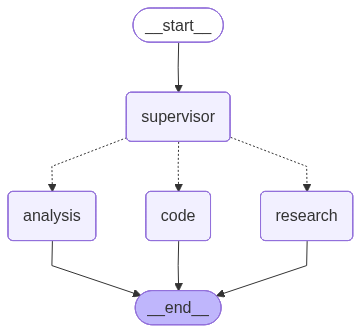

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
initial_state = {
    "trace_id": str(uuid.uuid4()),
    "user_input": "Explain agentic ai in two sentence",
    "route": "",
    "response": ""
}

for event in graph.stream(initial_state):
    pass

Agentic AI refers to artificial intelligence systems that autonomously set goals, select actions, and adapt strategies to achieve those goals with minimal human input. Because autonomous goal pursuit can diverge from human intent, robust alignment, safety controls, and governance are essential to ensure beneficial outcomes and maintain human oversight.